# Step 5: Evaluation of the model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams

import string
# may also be worth to try stanza https://stanfordnlp.github.io/stanza/index.html

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# for word cloud
import csv
from wordcloud import WordCloud


In [2]:
# load data
df = pd.read_csv('finalnouns.csv', index_col=0)

In [5]:
#initialize tokenizer and stemmer
tokenizer = RegexpTokenizer('[^\W\d_]+') #https://stackoverflow.com/questions/6067592/regular-expression-to-match-only-alphabetic-characters
stemmer = SnowballStemmer("norwegian", ignore_stopwords=True)

def clean(doc):   
    doc_ = doc

    # make all lower case
    doc_ = doc_.lower()
    
    # tokenize text. regex includes alphabetic characters, including letters with accents. 
    # excludes punctuation and numbers.
    words = tokenizer.tokenize(doc_)
    
    
    # do not stem stopwords
    stems = list(map(stemmer.stem, words))

    doc_ = " ".join(stems)
    
    # count number of words 
    n_words = len(words)

    return doc_#, title_words, n_words

In [6]:
# clean titles
df.nouns_clean = df.Nounss.apply(clean)

# convert titles to list of strings
nouns_words = df.nouns_clean.apply(lambda x: x.split(' '))

<ipython-input-6-7afe24557220>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.nouns_clean = df.Nounss.apply(clean)


In [9]:
# write norwegian stopwords to file
file2write=open("/Users/nimrarana/Downloads/norwegian_stopwords.txt",'w')
file2write.write('\n'.join(stopwords.words('norwegian')))
file2write.close()

# read stopwords from file
sw = [line.strip("\n") for line in open("/Users/nimrarana/Downloads/norwegian_stopwords.txt", "r")]

In [10]:
# show example of how tokenizer works
totoke = df.Nounss.values[3]
print('Original title : ' + totoke)
print(tokenizer.tokenize(totoke))
print(list(map(stemmer.stem, tokenizer.tokenize(totoke))))

totoke = df.Nounss.values[1]
print('Original title : ' + totoke)
print(tokenizer.tokenize(totoke))
print(list(map(stemmer.stem, tokenizer.tokenize(totoke))))

Original title : ['Sandra', 'Lyng']
['Sandra', 'Lyng']
['sandr', 'lyng']
Original title : ['Oslo-Fergenes', 'dag', 'fjorden']
['Oslo', 'Fergenes', 'dag', 'fjorden']
['oslo', 'ferg', 'dag', 'fjord']


In [11]:
# create n-grams
print(list(ngrams(nouns_words[1], 2)))

[('oslo', 'ferg'), ('ferg', 'dag'), ('dag', 'fjord')]


In [12]:
# initialize vectorizer to count words, ignoring norwegian stopwords
vectorizer = CountVectorizer(stop_words=sw)

# fit vectorizer to corpus of nouns
vectorizer.fit(df.nouns_clean)

# Looking at a small sample of the vocabulary:
vocabulary = list(vectorizer.vocabulary_.keys())
print("Small sample of the vocabulary:", vocabulary[0:20])

# Number of words in the vocabulary
print("\nNumber of distinct words:", len(vocabulary))

# convert data to word counts
word_count_matrix = vectorizer.transform(df.nouns_clean.values)

print('Word count vectorization has %d entries and %d words' % word_count_matrix.shape)

Small sample of the vocabulary: ['færr', 'klimakris', 'tiltak', 'koronapandemi', 'oslo', 'ferg', 'dag', 'fjord', 'raid', 'bankrøver', 'brasil', 'sandr', 'lyng', 'aborttilgang', 'tex', 'lov', 'høyesterett', 'brannfolk', 'øving', 'vilj']

Number of distinct words: 37317
Word count vectorization has 87638 entries and 37317 words


In [13]:
# get total word count per word
word_count = np.squeeze(np.asarray(word_count_matrix.sum(axis=0)))

wc_df = pd.Series(word_count, index=vectorizer.get_feature_names())



/Users/nimrarana/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# initialize TF-IDF counter
tfidf = TfidfTransformer()

# fit and transform to titles corpus
word_term_frequency_matrix = tfidf.fit_transform(word_count_matrix)

word_term_frequency_matrix

<87638x37317 sparse matrix of type '<class 'numpy.float64'>'
	with 287478 stored elements in Compressed Sparse Row format>

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [35]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [36]:
ac = AgglomerativeClustering(n_clusters=680, linkage='complete', distance_threshold=None)
ac.fit_predict(tf)

array([595, 449, 489, 353, 419, 678, 465, 484, 603, 455, 352, 663, 165,
       165, 365, 513, 575, 373, 350, 349, 348, 382, 431, 399, 347, 587,
       346, 662, 345, 622, 398, 515,  67, 343, 627, 344, 586, 474, 509,
       342, 434, 564, 364, 511, 341, 521, 442,  10, 504, 589, 393, 677,
       563, 464,  17, 672,  41,  41, 671, 385, 669, 541, 607, 456, 429,
        38,  38,  38, 374, 379,  26, 667, 665, 635, 574, 664, 661, 367,
       460, 447, 625, 659, 432, 457, 361, 619, 401,  76,  76, 478,  65,
       648, 409, 481,  58,  58, 463, 331, 546, 658, 655, 653, 538, 593,
        65,  65,  65, 356,  65,  65,  65,  65,  65,  65,  65, 651, 358,
       649, 400, 433,  32,  10, 654, 645, 558, 467, 234, 234,  57, 641,
       537, 639, 354, 199, 522, 523, 461, 129, 129, 637, 129, 440, 492,
       670, 458, 633, 430,  12, 403, 528, 351, 598, 216, 414,  10, 542,
       638, 629, 140,  50,  50,  50,  32,  32, 491,  50,  50,  50,  50,
        50,  32,  32,  50,  50,  50, 529, 527,  12,  97, 626,  8

### Comparing Results of Agglomerative clustering of nouns with previosly implemented model of making clusters using full titles (by Marina Fredmin)

In [37]:
# predicted values
predicted_values = [595, 449, 489, 353, 419, 678, 465, 484, 603, 455, 352, 663, 325,
       325, 345, 608, 575, 373, 350, 349, 351, 382, 431, 399, 347, 587,
       346, 662, 172, 622, 398, 515, 128, 378, 627, 344, 586, 444, 509,
       343, 434, 564, 364, 537, 342, 360, 667,  22, 504, 589, 428, 677,
       563, 570,  35, 672,  86,  86, 671, 385, 669, 541, 607, 456, 429,
       148, 148, 148, 551, 379,  27, 533, 665, 635, 574, 664, 661, 367,
       460, 447, 625, 659, 432, 457, 361, 623, 401,  87,  87, 478,  91,
       648, 409, 481,  13,  13, 463, 331, 546, 658, 655, 340, 538, 593,
        91,  91,  91, 356,  91,  91,  91,  91,  91,  91,  91, 410, 358,
       649, 459, 407,  32,  22, 654, 645, 558, 458,  52,  52,  10, 641,
       268, 639, 354, 400, 522, 523, 461,  49,  49, 637,  49, 440, 486,
       640, 477, 633, 430,   6, 403, 528, 471, 598, 433, 414,  22, 629,
       638, 628,  37, 102, 102, 102,  32,  32, 626, 102, 102, 102, 102,
       102,  32,  32, 102, 102, 102, 576, 527,   6, 195, 653,  41, 601,
       511,  35,  22, 599, 446, 290, 290, 226,  83,  83, 226, 290, 611,
       613, 162, 162,  17,  45, 652,  22,  45, 642,  22, 544,  97,  72,
       588, 557, 502, 341,  22, 614, 542, 196, 313,  40, 464, 466, 422,
        87, 605,  37, 679,  17,  46, 670, 232,  46, 617,  46, 539,  14,
        14, 644, 606, 426, 408, 624, 417, 454,  40, 488,  87, 519,  40,
       597, 596, 480, 594,  13,  13, 646, 559, 591, 612, 535, 196, 186,
       196, 196, 196, 196, 196, 196, 196, 590, 675, 604, 579, 319, 392,
        97, 473, 335, 498, 270, 107, 107, 107, 107, 107, 107, 470,  55,
       210, 620, 293,  30, 441, 406, 585, 362,  31,  31, 479, 592, 673,
       552, 210, 618, 521, 630, 581, 524, 516, 580, 577, 363, 609, 390,
        97, 197, 334, 482, 197, 547, 228,  97,  97,  97,  97,  97,  97,
        97, 387, 647,  97,  70, 107, 573,  70, 107,   6, 619, 107, 508,
        48, 305,  98,  98,  98, 491, 569, 187, 107, 187, 615, 536, 231,
        80, 194, 194, 357, 657,  80,  41, 505,  10,  10, 565, 448, 445,
       507, 666, 476,  62,  62,  62,  62,  54,  54, 631, 485, 332, 583,
       534, 371, 311, 540, 499, 510, 497, 389,  28, 566,  48, 668,  48,
        48,  48,  48,  48,  48,  28, 495, 475, 561, 306,  25,  25, 171,
       312, 660, 560, 438,  25, 355, 676, 506, 267, 567, 380, 425, 242,
        25, 483, 469, 451, 297, 405, 282,  79, 634,  43,  43, 263, 543,
        79, 287, 548, 239,  79, 292,  48,  48,  48, 309,  48,  48, 279,
       252,   5, 616, 610, 237,   3,  37, 146, 328, 636,  48,  48,  48,
        48,  48, 439,  50, 269,  48,  48,  48, 462,  61, 301,  61,  61,
       402, 241, 338, 436, 450,  25,  73,  73, 227,   5, 514, 496, 390,
       632, 490,  28, 188,  36, 155,  36, 452, 529,  53,  53, 104, 423,
       568, 132, 104, 132, 443, 372, 602, 326, 359,  18, 435,  18,  72,
       185, 437, 650, 217, 366,  37, 302,  12,  12, 215,  50,  30,  12,
       555, 487, 424,  65, 320,  51,  51,  19, 112, 427, 195, 112, 415,
       525,  25, 170, 211, 244, 266,  28, 222, 562, 553, 442, 420, 545,
        71, 323, 275,  65, 395, 388, 134, 133,  23, 530, 203, 202, 643,
        96, 264, 221, 223, 656, 229, 212, 397, 339,  96, 394,  23, 526,
       386,  94,  94, 674, 571, 314, 418, 377,  75, 336,  85, 303, 550,
       572,  75, 220, 391, 272, 156, 200, 329, 234, 365, 181, 300,  44,
        44,  66,  72, 159, 178, 368, 549, 554, 512,  72,  72,  63,   2,
        72,  21,  39, 520,  21, 376,  63, 259,  63,  63, 192,  63,  63,
        63,  64,  63, 286,  63, 150,   2,  63,  39,   2,   2,   2,   2,
         2,   2, 316,   2,   2, 128, 621, 532,   4,  19, 333, 513,  19,
       166, 186,   4, 186, 255, 600,   3, 383, 295,  28,   3,  26,   9,
         9, 274, 330, 240, 327, 315, 177, 369,  25,  25, 321, 225, 284,
        29, 163, 348, 157,  64, 518, 317, 492, 283, 218, 214, 310, 299,
       149, 298, 169, 384, 413,   7,   7, 253, 501, 289, 198, 318, 494,
       281, 260, 556, 404,  84, 472, 278, 273,  16, 280,  59, 517,  16,
       238, 188, 257, 209, 276, 396, 531, 131, 261, 578, 370, 468, 474,
        42,  42, 584, 503, 262, 256,  92, 285, 324, 243,  93,  93, 142,
       180, 337,   3,  28,   3,  28, 184, 191,  25, 154, 493, 179, 251,
       500,  77, 467, 115,  56,  56,  56,  56, 288,  56,  56,  56,  56,
       233, 219, 168,  25, 208,   3, 213,  27,  27, 416, 121, 216, 236,
       199, 277,  26, 582,  38,  38,  38,  38,  38,  38,  38,  38, 105,
         1, 127, 246, 411, 291,  59, 375,  15,  15,  15, 307, 294, 245,
        82,  30, 193,  82, 189,  82,  82,  92,  20,  82,  82,  82,  82,
        82, 165, 230, 271, 118,   8, 129, 176, 136, 201,  28, 182, 158,
       164, 174, 247, 140,  38, 122, 254, 421,  28, 322, 141,  29, 167,
        33,  47,  28, 224, 304,  47, 206, 412, 137,  33, 135,  90, 173,
       143, 249, 145, 139,  67, 100, 235, 381, 151, 175, 308, 248, 374,
       153,  38, 117,  20,  38,  38, 204, 113, 205,  38,  58, 110, 130,
       106, 126,  81,  15,  20, 123,  56,  15, 265, 250, 116, 119,  29,
        20, 453,  20,   8,  20, 258,  20, 125,  20,  20,  20,  20, 183,
        20,  60, 393,  15,  15,  15, 393,  15, 296, 114, 124,  15, 393,
         1,   0,   0,   0, 114, 114,  15, 138,   0,  55,  24, 146,  24,
         3,   4,  55,  99,  29,  99,  29,  99,  29,  29,  29,  57,  29,
        76, 109,  34, 207,  34,  99,  26,  29,  11, 108,  11,  29,  99,
        29,  68,  99,  76,  29, 152,  78, 111, 190, 103, 101,  88, 651,
       120, 147, 144,  11,  71, 144,  74,  28,  69, 144, 144, 160,  71,
       161,  95,  89,  59,  59,  59,  11,  59,  59,  59,  59,  59]
print(len(predicted_values))

1000


In [38]:
#setting cluster numbers got from applying agglomerqative clustering of complete titles (Model of Marina Fredmin)
#ground truth
target_variables = [598, 431, 538, 509, 384,   2, 424, 511, 579, 454, 605,  16,  79,
        79, 359, 668, 644, 355, 507, 542, 603, 655, 667, 420, 389, 576,
       607,  12, 508, 647, 372, 540,  56, 577, 666, 610, 616, 423, 553,
       601, 440, 593, 356, 526, 435, 344, 448,  22, 434, 580, 613, 659,
       467,  12,   4,   4,  80,  80, 527, 364, 562, 645, 346, 375, 473,
        58,  58,  58, 646, 615, 660, 369, 513,  24, 572, 583, 522, 530,
       410, 459, 594, 661, 475, 617, 381, 602, 366,  18,  18, 465, 117, 
       656, 406, 642,  14,  14, 470,  29, 461, 536, 581, 289, 651, 622,
       117, 117, 117, 380, 117, 117, 117, 117, 117, 117, 117, 477, 447,
       604, 438, 611,  47, 614, 648, 550, 551, 595,  60,  60,  24, 350,
       582, 573, 352, 253, 469, 499, 528, 168, 168, 600, 168, 596, 383,
       635,  29, 589, 404, 678, 631, 574, 591, 560, 485, 484,  24, 563,
       629, 637, 135,  62,  62,  62,  47,  47, 263,  62,  62,  62,  62,
        62,  47,  47,  62,  62,  62, 234, 427, 658, 231, 673, 114, 531,
       494,   4,  24, 468, 399,  36,  36,  54, 125, 125,  54,  36, 561,
       466,  69,  69,  27,  63, 662,  24,  63, 649,  24, 592,  82,  19,
       630, 497, 545, 397,  24, 458, 418, 102, 612,   6, 663, 590, 362,
        18, 361, 135, 555,  27,  23,  18, 523,  23, 377,  23, 552,   1,
         1, 599, 539, 546, 433, 643, 618, 360,   6, 474,  18, 535,   6,
       556, 510, 515, 414,  14,  14,   2, 478, 547,  30, 619, 102, 107,
       102, 102, 102, 102, 102, 102, 102, 417, 634, 327, 432, 674, 409,
       679, 623,  11, 653,  11,   7,   7,   7,   7,   7,   7, 490, 106,
       181, 625, 543,  72, 537, 351, 457, 339,  45,  45, 403, 488, 569,
       518, 181, 585, 393, 208, 368, 584, 373, 442, 608, 426, 400,  91,
        82, 123, 268, 358, 123, 348, 450,  82,  82,  82,  82,  82,  82,
        82, 345, 640,  82, 207,   7, 501, 207,   7,  30, 532,   7, 272,
        57, 578,  95,  95,  95, 425, 199, 157,   7, 157, 628, 476, 322,
       140,  83,  83, 349,   7, 140, 114, 449, 544,  22, 301, 374, 652,
       571, 654, 487,  26,  26,  26,  26,  96,  96, 670, 606, 303, 493,
       524, 386, 302, 505, 521, 460, 586, 387, 529, 343,  57, 401,  57,
        57,  57,  57,  57,  57, 305, 621, 514, 395, 329,  25,  25, 439,
       627, 295, 456, 657,  25, 565, 677, 624, 564, 342, 502, 472, 419,
        25, 328, 486, 211, 382, 402, 275, 156, 326,  52,  52, 378, 665,
       156, 390, 246, 232, 156, 291,  57,  57,  57, 597,  57,  57, 534,
       557, 446, 407, 541, 330,   8, 135, 293, 341, 405,  57,  57,  57,
        57,  57, 270,  42, 570,  57,  57,  57, 558, 176, 297, 176, 176,
       228, 489,  13, 421, 559,  25, 146, 146, 388, 506, 554, 483,  91,
       209, 428, 398,  61,  51, 376,  51, 481, 492,  59,  59,  44, 323,
       254, 139,  44, 139, 437, 549, 288, 242, 170,  71, 213,  71,  19,
       321, 429, 626, 396, 371, 135, 392,  37,  37, 379,  42,  72,  37,
       236, 274, 223,   6, 311,  48,  48,  90,  43, 503, 231,  43, 385,
       525,  25, 353, 250, 216, 639, 609, 444, 632, 500, 548, 306, 186,
        88, 204, 340,   6, 290, 292, 675, 430,  32, 498, 363, 408, 248,
        99, 332, 394, 264,  10, 194, 179, 265,  10,  99, 193,  32, 567,
       504,  20,  20, 416, 347, 307, 436, 482,  81, 676, 325, 495, 267,
       391,  81, 453, 462, 411,   5, 188, 669, 354, 271, 533, 451,  86,
        86, 286,  19, 520, 191, 664, 126, 566, 200,  19,  19, 175,  49,
        19,   9,  46, 308,   9, 266, 175, 294, 175, 175, 365, 175, 175,
       175,  97, 175, 163, 175, 152,  49, 175,  46,  49,  49,  49,  49,
        49,  49, 285,  49,  49,  56, 650, 189,   0,  90,  15,   5,  90,
       319, 107,   0, 107, 180,  15,   8, 224, 212, 296,   8,  40,   3,
         3, 249, 422, 452, 262, 217, 313, 671,  25,  25, 443, 480, 150,
        31,  17, 575, 276,  97, 331, 226, 197, 182, 314, 672, 173, 310,
       636, 273, 317, 641, 172,  16,  16, 160, 142, 568, 261, 221, 519,
       201, 237, 471, 190, 633, 131, 144, 259,  33, 132,  38, 169,  33,
       455,  61, 111,  17, 283, 298, 620, 491, 415, 284, 219, 241, 203,
        78,  78, 320, 120, 357, 334, 143, 587, 517, 269, 115, 115, 370,
       337, 312,   8, 104,   8, 104, 280, 278,  25, 137, 229, 463, 162,
       260, 309, 235, 202, 129, 129, 129, 129, 238, 129, 129, 129, 129,
       282, 413, 335,  25, 304,   8,  84,  87,  87, 195, 516, 185, 279,
       324, 333,  40, 154, 316, 316, 316, 316, 316, 316, 316, 316, 198,
        21, 277, 187, 287, 206,  38,  94,  41,  41,  41, 225, 315, 445,
       183,  72, 256, 183,  92, 183, 183, 143,  76, 183, 183, 183, 183,
       183, 588, 233, 244, 171,  77, 148,  98, 251, 101, 638, 230, 512,
       336, 218, 147, 138, 316, 479, 222,  65,  35, 210, 159,  31,  85,
       103,  53,  35, 299, 110,  53, 258, 227, 281, 103, 239, 151, 141,
       255,  73, 113, 116, 100, 134, 243, 165, 133, 127, 178, 464, 121,
       108, 316, 496,  76, 316, 316, 118, 245, 174, 316, 164, 240, 257,
       441, 215, 130,  13,  76,  93, 129,  41, 177, 184, 300, 338,  31,
        76, 128,  76,  77,  76,  68,  76,  89,  76,  76,  76,  76, 214,
        76, 161,  64,  41,  41,  41,  64,  41, 155, 166, 112,  41,  64,
        21,  28,  28,  28, 166, 166,  41, 105,  28, 106,  50, 293,  50,
         8,   0, 106,  34,  31,  34,  31,  34,  31,  31,  31, 167,  31,
        39, 220, 192, 124, 192,  34,  40,  31,  67, 145,  67,  31,  34,
        31, 119,  34,  39,  31, 153, 318, 122, 136, 252, 412, 149,  74,
        55, 196,  70,  67,  88,  70, 367, 109, 247,  70,  70, 158,  88,
        75, 205,  66,  38,  38,  38,  67,  38,  38,  38,  38,  38]

print(len(target_variables))

1000


In [39]:
#calculating Fowlkes_mallows_score
from sklearn.metrics.cluster import fowlkes_mallows_score
fowlkes_mallows_score(predicted_values, target_variables)

0.9450273983309313

In [40]:
# calculating silhoute score to evaluate coherrence of clusters
from sklearn.metrics import silhouette_score
silhouette_score(tf,labels=ac.fit_predict(tf))

0.36457631060251106

plt.scatter(predicted_values, target_variables,"o")
plt.show()

plt.scatter() 9.219899209000005
plt.plot() 0.6322819060000029


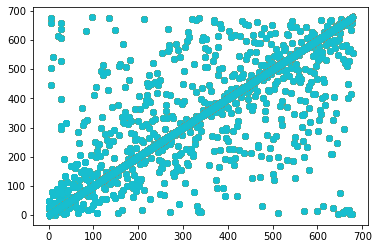

In [44]:
import timeit
import matplotlib.pyplot as plt



print(
    "plt.scatter()",
    timeit.timeit(
        "plt.scatter(predicted_values, target_variables)",
        number=1000,
        globals=globals(),
    ),
)
print(
    "plt.plot()",
    timeit.timeit(
        "plt.plot(predicted_values, predicted_values, 'o',marker='d')",
        number=1000,
        globals=globals(),
    ),
)